#Mahdi ramezaan zaade (40024544)
Dr. Mashayekhi, Spark exercise

# install packages and download dataset

In [1]:
!pip install pyspark scipy pandas
!wget https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/artificial/fourty.arff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 27 kB/s 
     |████████████████████████████████| 198 kB 50.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=562d3f1bb3b005fdebb96785c3da8a72bc31313f5937915bc5171008c406456e
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
--2022-06-06 16:27:02--  https://raw.githubusercontent.com/deric/clustering-benchmark/master/src/main/resources/datasets/artificial/fourty.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19266 (19K) [text/plain]
Saving to: ‘fourty.arff’

fourty.arff     

# load dataset
dataset consist of points that each has three columns:


*   x: horizontal postion of a point
*   y: vertical postion of a point
*   class: numeric category of point wich it belong to


to work with data in spark we need data in form of a spark Rdd dataframe. rdd can be generated from pandas dataframe. first we convert our weka dataset (arff format) to a pandas dataframe. scipy package that is preinstalled can do this convertion.

we implement this convertion process as a function that return our generated pandas dataframe.

In [2]:
from scipy.io import arff
import pandas as pd

def df_generator():
  data = arff.loadarff('fourty.arff')
  df = pd.DataFrame(data[0])
  df['class'] = df['class'].astype(int)
  return df


# create spark context and session
for using spark we should create a `SparkContext` thah is used for clusters management by spark. then we create our Rdd dataframe with `SparkSession`.

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext,SparkConf

sc = SparkContext('local','MMD').getOrCreate()
ss = SparkSession.builder.getOrCreate()

df = ss.createDataFrame(df_generator(), ['x','y','class'])

# normilize and split data

to use spark `Normalizer` for normilizing our `x` and `y` columns we should create a new `Vector` column of those columns. we do this with help of spark `VectorAssembler`. the name of new vector column that will be created is `features`. then we use `Normalizer` on `featurse` column to create new `featurse_norm` vector column that is normalized vector of features vector.
to do this process in pralell with spark we will create a `Pipeline` and pass our process stages. 

at last step we call `randomSplit` function to split data in two dataset wich one contain 10 and other one contain 90 percent of data selected randomly.

In [4]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=['x','y'], outputCol='features')
normalizer = Normalizer(inputCol='features', outputCol='features_norm', p=1.0)

pipeline = Pipeline(stages=[assembler, normalizer])

data_model = pipeline.fit(df)
transformed_df = data_model.transform(df)

[test,train] = transformed_df.randomSplit([0.1,0.9])
train.head()

Row(x=-1.64307, y=16.7766, class=20, features=DenseVector([-1.6431, 16.7766]), features_norm=DenseVector([-0.0892, 0.9108]))

# run k-means algorithem and evalute the model
`spark.ml` have both K-Means algorithem & clustring evaluteror. first we create our evalutor using `ClusteringEvaluator` and the set `featues_norm` as features column of data.

then we create our Kmeans model and set k = 40 and `featues_norm` as features column. in next step we fit model on train dataframe. then use test dataframe to get output of model prediction on it called `predition`. now we evalute output using our evalutor and print the score.

In [5]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(featuresCol="features_norm", predictionCol='prediction', k=40, seed=1)
kmeans_model = kmeans.fit(train)
predictions = kmeans_model.transform(test)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features_norm', metricName='silhouette', distanceMeasure='squaredEuclidean')

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6552771062402343


#visualize
first we visualize `test` dataframe with real categories of data to see how points are categorized so we can compare it to our model predictions.

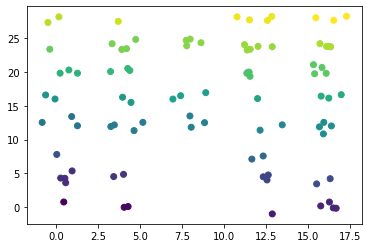

In [6]:
import matplotlib.pyplot as plt

d = predictions.toPandas()
plt.scatter(d['x'], d['y'], c=d['class'])

now we visualize `test` dataframe with our model categories prediction and compare it with original categories of pionts visualy.

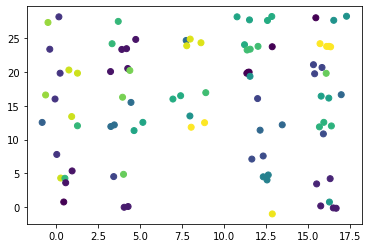

In [7]:
plt.scatter(d['x'], d['y'], c=d['prediction'])

end.